In [1]:
import torch
import numpy as np
import random
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import progressbar

In [2]:
device_gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using ' + device_gpu.type)

Using cuda


In [3]:
PAD_CHAR = ' '
english_alphabets = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
english_char_to_index_map = {}
english_char_to_index_map[PAD_CHAR] = 0
for index,char in enumerate(english_alphabets):
  english_char_to_index_map[char] = index+1
print(english_char_to_index_map)

{' ': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26}


In [4]:
hindi_alphabets = [chr(alpha) for alpha in range(2304, 2432)]
hindi_alphabet_size = len(hindi_alphabets)
hindi_char_to_index_map = {}
hindi_char_to_index_map[PAD_CHAR] = 0
for index,ch in enumerate(hindi_alphabets):
  hindi_char_to_index_map[ch] = index+1
print(hindi_char_to_index_map)

{' ': 0, 'ऀ': 1, 'ँ': 2, 'ं': 3, 'ः': 4, 'ऄ': 5, 'अ': 6, 'आ': 7, 'इ': 8, 'ई': 9, 'उ': 10, 'ऊ': 11, 'ऋ': 12, 'ऌ': 13, 'ऍ': 14, 'ऎ': 15, 'ए': 16, 'ऐ': 17, 'ऑ': 18, 'ऒ': 19, 'ओ': 20, 'औ': 21, 'क': 22, 'ख': 23, 'ग': 24, 'घ': 25, 'ङ': 26, 'च': 27, 'छ': 28, 'ज': 29, 'झ': 30, 'ञ': 31, 'ट': 32, 'ठ': 33, 'ड': 34, 'ढ': 35, 'ण': 36, 'त': 37, 'थ': 38, 'द': 39, 'ध': 40, 'न': 41, 'ऩ': 42, 'प': 43, 'फ': 44, 'ब': 45, 'भ': 46, 'म': 47, 'य': 48, 'र': 49, 'ऱ': 50, 'ल': 51, 'ळ': 52, 'ऴ': 53, 'व': 54, 'श': 55, 'ष': 56, 'स': 57, 'ह': 58, 'ऺ': 59, 'ऻ': 60, '़': 61, 'ऽ': 62, 'ा': 63, 'ि': 64, 'ी': 65, 'ु': 66, 'ू': 67, 'ृ': 68, 'ॄ': 69, 'ॅ': 70, 'ॆ': 71, 'े': 72, 'ै': 73, 'ॉ': 74, 'ॊ': 75, 'ो': 76, 'ौ': 77, '्': 78, 'ॎ': 79, 'ॏ': 80, 'ॐ': 81, '॑': 82, '॒': 83, '॓': 84, '॔': 85, 'ॕ': 86, 'ॖ': 87, 'ॗ': 88, 'क़': 89, 'ख़': 90, 'ग़': 91, 'ज़': 92, 'ड़': 93, 'ढ़': 94, 'फ़': 95, 'य़': 96, 'ॠ': 97, 'ॡ': 98, 'ॢ': 99, 'ॣ': 100, '।': 101, '॥': 102, '०': 103, '१': 104, '२': 105, '३': 106, '४': 107, '५': 108, '६': 109, '७': 110,

In [5]:
def clean_english_input(input):
    input = input.replace(',',' ')
    input = input.replace('-', ' ')
    res = ''
    for ch in input:
        if (not ch in english_alphabets) and ch!=' ':
          continue
        res = res + ch
    return res.strip().split()
    

In [6]:
def clean_hindi_input(input):
    input = input.replace(',',' ')
    input = input.replace('-', ' ')
    res = ''
    for ch in input:
        if (not ch in hindi_alphabets) and ch!=' ':
            continue
        res = res + ch
    return res.strip().split()

In [7]:
import xml.etree.ElementTree as ET

class TransliterationDataLoader():

  def __init__(self,file_name, verbose = False):
    
    self.verbose = verbose 
    self.english_names,self.hindi_names = self._read_xml_file(file_name)
    self.shuffle_indices = list(range(0,len(self.english_names)))
    random.shuffle(self.shuffle_indices)
    self.start_index = 0
    

  def get_size(self):
    return len(self.english_names)

  def _get_item(self,idx):

    return self.english_names[idx],self.hindi_names[idx]
  
  def get_random_sample(self):

    return self._get_item(np.random.randint(0,len(self.english_names)))


  def _get_batch_words(self, words, start, end):
      return words[start : end]


  def get_batch(self,batch_size):

      end = self.start_index + batch_size
      actual_end = end

      if end>self.get_size():
          actual_end = self.get_size()
      
      eng_batch = self._get_batch_words(self.english_names, self.start_index, actual_end)
      hindi_batch = self._get_batch_words(self.hindi_names, self.start_index, actual_end)

      if end>self.get_size() :
          eng_batch.extend(self._get_batch_words(self.english_names, 0, end - actual_end))
          hindi_batch.extend(self._get_batch_words(self.hindi_names, 0, end - actual_end))
      
      if end>= self.get_size():
          random.shuffle(self.shuffle_indices)
          self.start_index = 0
      else:
          self.start_index = end

      return eng_batch, hindi_batch


  def _read_xml_file(self,file_name):

      doc_tree = ET.parse(file_name)
      doc_root = doc_tree.getroot()
      english_names = []
      hindi_names = []

      for name in doc_root.findall('Name'):
          english_name = name.find('SourceName').text 
          hindi_name = name.find('TargetName').text
          english_words = clean_english_input(english_name.upper())
          hindi_words = clean_hindi_input(hindi_name)

          if(len(english_words)!=len(hindi_words)):
              if self.verbose : 
                  print('Skipping : ' + english_name + ' : ' + hindi_name)
                  print(english_words)
                  print(hindi_words)

              continue
          
          english_names.extend([word for word in english_words])
          hindi_names.extend([word for word in hindi_words])

      return english_names,hindi_names

In [8]:
train_data_loader = TransliterationDataLoader('./eng-hindi-train.xml')


In [9]:
train_data_loader.get_random_sample()

('KE', 'के')

In [10]:
def name_encode_input(char_map, name):

    name_vec = torch.zeros(len(name)+1 , 1 , len(char_map)).to(device_gpu)

    for index,ch in enumerate(name) :
        pos = char_map[ch]
        name_vec[index][0][pos] = 1

    name_vec[index+1][0][char_map[PAD_CHAR]] = 1
    return name_vec

    

In [11]:
def name_encode_output(char_map, name):

    name_vec = torch.zeros(len(name)+1 , 1).to(device_gpu)

    for index,ch in enumerate(name) :
        pos = char_map[ch]
        name_vec[index][0] = pos

    name_vec[index+1][0] = char_map[PAD_CHAR]
    return name_vec

In [12]:
def batch_encode_input(char_map, names) :

    max_size = max(list(map(lambda x : len(x), names)))
    batch_input_vec = torch.zeros(max_size, len(names), len(char_map)).to(device_gpu)
    lengths = []
    for name_index, name in enumerate(names) :
        for batch_index,ch in enumerate(name) :
            pos = char_map[ch]
            batch_input_vec[batch_index][name_index][pos] = 1
        
        lengths.append(len(name))

    packed_vec = torch.nn.utils.rnn.pack_padded_sequence(batch_input_vec, lengths, enforce_sorted=False).to(device_gpu)
    return packed_vec

def batch_encode_output(char_map, names) :

    max_size = max(list(map(lambda x : len(x), names)))
    batch_output_vec = torch.zeros(max_size, len(names)).type(torch.LongTensor).to(device_gpu)

    for name_index, name in enumerate(names) :
        for batch_index,ch in enumerate(name) :
            pos = char_map[ch]
            batch_output_vec[batch_index][name_index] = pos

    return batch_output_vec.unsqueeze(2).to(device_gpu)


In [13]:
eng_batch, hindi_batch = train_data_loader.get_batch(8)
input_batch = batch_encode_input(english_char_to_index_map, eng_batch)
output_batch = batch_encode_output(hindi_char_to_index_map, hindi_batch)
print(input_batch.batch_sizes)
print(output_batch.shape)

tensor([8, 8, 8, 8, 6, 5, 3, 3, 2, 2, 2, 2, 1])
torch.Size([10, 8, 1])


In [14]:
import torch.nn as nn

class TransliterationEncoderDecoder(nn.Module):

    def __init__(self, input_size, hidden_size, output_size, verbose=False):

        super(TransliterationEncoderDecoder,self).__init__()
        self.output_size = output_size

        self.enc_rnn_cell = nn.GRU(input_size, hidden_size)
        self.dec_rnn_cell = nn.GRU(output_size, hidden_size)
        self.hidden_to_out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)
        self.verbose = verbose

    def forward(self, input, max_output_size, batch_size = 1,  ground_truth = None, device = 'cpu'):

        outputs = []

        enc_out, enc_hidden = self.enc_rnn_cell(input)

        dec_hidden = enc_hidden
        dec_input = torch.zeros(1, batch_size, self.output_size).to(device)

        for i in range(max_output_size):
            dec_out, dec_hidden = self.dec_rnn_cell(dec_input, dec_hidden)
            dec_out = self.hidden_to_out(dec_hidden)
            
            dec_out = self.softmax(dec_out)
            outputs.append(dec_out.squeeze())

            max_idx = torch.argmax(dec_out, 2, keepdim=True)[0]
            if not ground_truth is None :
                max_idx = ground_truth[i]
            max_idx = max_idx.type(torch.LongTensor).to(device)

            if self.verbose :
                print(max_idx.shape)

            one_hot = torch.zeros(dec_out.shape).to(device)
            y = torch.ones(dec_out.shape).to(device)
            one_hot.zero_()
            one_hot.scatter_(2, max_idx.unsqueeze(0), y)
            decoder_input = one_hot.detach()
        
        return outputs

In [15]:
def train_net_batch_mode(net, loss_fn, opt, train_data_loader, batch_size, teacher_force = False, device = 'cpu'):

    net.train().to(device)
    opt.zero_grad()

    eng_batch, hindi_batch = train_data_loader.get_batch(batch_size)
    input_batch_vec = batch_encode_input(english_char_to_index_map, eng_batch)
    output_batch = batch_encode_output(hindi_char_to_index_map, hindi_batch)
    
    pred = net(input_batch_vec, output_batch.shape[0], batch_size = batch_size,  ground_truth = output_batch if teacher_force else None, device = device )
    pred = torch.stack(pred).transpose(0,1).to(device)
    pred = torch.transpose(pred, 1,2).to(device)
    output_batch = torch.transpose(output_batch, 0,1).to(device)
    
    loss = loss_fn(pred, output_batch.squeeze(2))
    loss.backward()

    opt.step()

    return loss




In [16]:
def train_driver_batch_mode(net, data_loader, batch_count, batch_size, lr = 0.01, device = 'cpu') :

    net.to(device)
    loss_fn = nn.NLLLoss()
    opt = optim.Adam(net.parameters(), lr = lr)

    losses = np.zeros(batch_count + 1)

    for i in progressbar.progressbar(range(batch_count)) :
        losses[i+1] = (losses[i]*i + train_net_batch_mode(net, loss_fn, opt,  data_loader, batch_size, teacher_force = (i<batch_count), device = device))/(i+1)
    
    torch.save(net,'enc-dec.pt')
    return losses


In [42]:
net = TransliterationEncoderDecoder(len(english_char_to_index_map), 512, len(hindi_char_to_index_map),verbose=False)

In [45]:
losses = train_driver_batch_mode(net, train_data_loader, 16000, 16, device = device_gpu, lr=0.001)

100% (16000 of 16000) |##################| Elapsed Time: 0:05:29 Time:  0:05:29


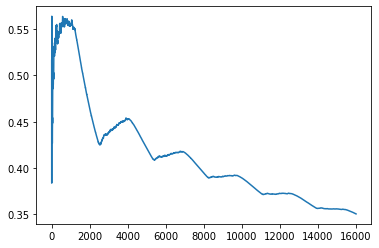

In [46]:
plt.plot(losses[1:])

In [21]:
def infer(net,input,output_size):

    net.eval().to(device_gpu)

    input_vec = batch_encode_input(english_char_to_index_map,[input])
    pred = net.forward(input_vec,output_size, batch_size = 1,  device = device_gpu)
    
    out = ''

    for vec in pred:
        max_idx = torch.argmax(vec)
        ch = list(hindi_char_to_index_map.keys())[list(hindi_char_to_index_map.values()).index(max_idx)]
        out = out + ch
    
    return out

In [57]:
print(infer(net, 'INDIA', 6))

इंडिया


In [17]:
import torch.nn as nn

class TransliterationEncoderDecoderWithAttention(nn.Module):

    def __init__(self, input_size, hidden_size, output_size, verbose = False):

        super(TransliterationEncoderDecoderWithAttention,self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.verbose = verbose

        self.enc_rnn_cell = nn.GRU(input_size, hidden_size)
        self.dec_rnn_cell = nn.GRU(hidden_size, hidden_size)

        self.embedding = nn.Linear(output_size, hidden_size)
        self.attention = nn.Linear(2* hidden_size, hidden_size)
        self.attn_enc = nn.Linear(hidden_size, 1)
        self.attn_applied = nn.Linear(2*hidden_size, hidden_size)

        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax_out = nn.LogSoftmax(dim=2)
        

    def forward(self, input, max_output_size, batch_size = 1,  ground_truth = None, device = 'cpu'):

        enc_outputs, enc_hidden = self.enc_rnn_cell(input)

        dec_input = torch.zeros(1, batch_size, self.output_size).to(device)
        dec_hidden = enc_hidden
        outputs = []
        enc_outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(enc_outputs)
        enc_outputs = torch.transpose(torch.transpose(self.attn_enc(enc_outputs),0,1),1,2).to(device)

        for i in range(max_output_size) :
            embed = self.embedding(dec_input)
            attn = F.softmax(self.attention(torch.cat((embed,dec_hidden),dim = 2)),dim=2)
            attn = torch.transpose(attn,0,1).to(device)
            mat_prod = torch.bmm(enc_outputs,attn.repeat(1, enc_outputs.shape[2], 1)).to(device)
            mat_prod = torch.transpose(mat_prod, 0, 1).to(device)
            if self.verbose :
                print('embed : ', embed.shape)
                print('attn : ', attn.shape)
                print('mat_prod : ', mat_prod.shape)

            attn_applied = self.attn_applied(torch.cat((mat_prod, embed),dim =2))

            dec_input = F.relu(attn_applied)

            dec_out, dec_hidden = self.dec_rnn_cell(dec_input, dec_hidden)

            dec_out = self.h2o(dec_hidden)
            dec_out = self.softmax_out(dec_out)
            outputs.append(dec_out.squeeze())

            max_idx = torch.argmax(dec_out, 2, keepdim=True)[0]
            if not ground_truth is None :
                max_idx = ground_truth[i]
            max_idx = max_idx.type(torch.LongTensor).to(device)

            if self.verbose :
                print(max_idx.shape)

            one_hot = torch.zeros(dec_out.shape).to(device)
            y = torch.ones(dec_out.shape).to(device)
            one_hot.zero_()
            one_hot.scatter_(2, max_idx.unsqueeze(0), y)
            dec_input = one_hot.detach()

        return outputs


In [18]:
atn_net = TransliterationEncoderDecoderWithAttention(len(english_char_to_index_map), 512, len(hindi_char_to_index_map),verbose=False)
losses = train_driver_batch_mode(atn_net, train_data_loader, 32000, 16, device = device_gpu, lr = 0.001)

100% (32000 of 32000) |##################| Elapsed Time: 0:18:43 Time:  0:18:43


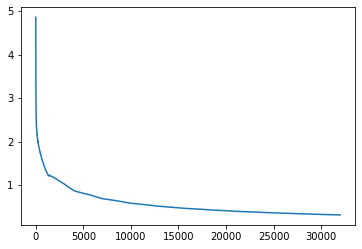

In [19]:
plt.plot(losses[1:])

In [62]:
infer(atn_net, 'UNIVERSITY', 11)


'यूनिवर्सिटी'

In [72]:
def infer_sentence(net, sentence) :

    words = sentence.split()
    res = list(map(lambda x : infer(net, x.strip(), len(x)*2).strip(), words))
    return ' '.join(res)

In [79]:
print(infer_sentence(atn_net, 'ARIZONA STATE UNIVERSITY'))

एरीज़ोना स्टेट यूनिवर्सिटी
